### Read in the libraries

In [210]:
import numpy as np
import pandas as pd
import matplotlib as plt
import seaborn as sns

In [211]:
def rename_columns_with_suffix(df, suffix="_BTC", exclude_columns=["Date"]):
    """
    Renames all columns in the given DataFrame by appending a suffix, 
    except for the specified columns.
    
    Parameters:
        df (pd.DataFrame): The DataFrame whose columns need to be renamed.
        suffix (str): The suffix to append to each column name.
        exclude_columns (list): List of column names to exclude from renaming.
    
    Returns:
        pd.DataFrame: A new DataFrame with updated column names.
    """
    df = df.copy()
    df.columns = [col + suffix if col not in exclude_columns else col for col in df.columns]
    return df

### Read in the data

In [212]:
btc = pd.read_excel('../data/pricing_data.xlsx', sheet_name='BTCUSD')

# Convert the 'Date' column to datetime format
btc['Date'] = pd.to_datetime(btc['Date'])

# Sort by date
btc = btc.sort_values(by='Date')

# Reset index if needed
btc.reset_index(drop=True, inplace=True)

btc = rename_columns_with_suffix(btc, "_BTC")

In [213]:
spy = pd.read_excel('../data/pricing_data.xlsx', sheet_name='SPY')

# Convert the 'Date' column to datetime format
spy['Date'] = pd.to_datetime(spy['Date'])

# Sort by date
spy = spy.sort_values(by='Date')

# Reset index if needed
spy.reset_index(drop=True, inplace=True)

spy = rename_columns_with_suffix(spy, "_SPY")

In [214]:
btc_returns = pd.read_csv("../data/btc_rf_predictions_rolling_returns.csv")

btc_returns = btc_returns.drop(columns=['Unnamed: 0'])

btc_returns["Date"] = pd.to_datetime(btc_returns["Date"])
btc_returns = rename_columns_with_suffix(btc_returns, "_BTC")

In [215]:
spy_preds = pd.read_csv('../data/spy_rf_predictions_rolling_returns_longwindow.csv')
spy_preds = rename_columns_with_suffix(spy_preds, "_SPY")
spy_preds['Date'] = pd.to_datetime(spy_preds['Date'])

In [216]:
df = pd.merge(btc, spy, on = "Date", how = "left")
df_combined_all = pd.merge(btc_returns, df, on = "Date", how = "left")
data_final = pd.merge(df_combined_all, spy_preds, on = "Date", how = "left")

In [217]:
#save overall data for usage
data_final.to_csv("../data/all_assets_combined_with_predicted_returns.csv")

In [218]:
#check head 
data_final.head()

,Date,Actual_BTC,Predicted_BTC,Open_BTC,High_BTC,Low_BTC,Close_BTC,SMAVG (5) on Close_BTC,SMAVG (10) on Close_BTC,SMAVG (15) on Close_BTC,...,Low_SPY,Close_SPY,SMAVG (5) on Close_SPY,SMAVG (10) on Close_SPY,SMAVG (15) on Close_SPY,Volume_SPY,SMAVG (5)_SPY,Unnamed: 0_SPY,Actual_SPY,Predicted_SPY
0,2025-01-01 00:00:00,-0.004864,-0.001040,95284.25,95437.53,94810.92,94819.27,95361.44,95103.27,94698.79,...,586.82,586.900,588.662,589.595,589.450,1592798.0,2713952.0,3136.0,-0.003108,-0.000381
1,2025-01-01 00:30:00,-0.001385,-0.001856,94819.27,94824.27,94497.53,94687.97,95154.90,95163.72,94756.23,...,586.54,587.060,588.422,589.242,589.450,1192807.0,1740555.0,3137.0,0.000273,0.000974
2,2025-01-01 01:00:00,-0.003476,-0.000240,94686.97,94864.25,94343.75,94358.80,94916.59,95134.91,94788.68,...,585.74,585.860,587.632,588.716,589.312,1309514.0,1446326.0,3138.0,-0.002044,-0.000098
3,2025-01-01 01:30:00,-0.004209,-0.000777,94358.80,94379.84,93090.16,93961.69,94622.09,95089.80,94796.01,...,584.90,587.205,587.151,588.405,589.172,2380319.0,1515197.0,3139.0,0.002296,0.000394
4,2025-01-01 02:00:00,-0.001337,-0.000166,93961.44,94237.84,93664.06,93836.11,94332.77,94910.44,94786.52,...,584.79,584.960,586.397,587.810,588.806,1876895.0,1670467.0,3140.0,-0.003823,-0.000294


### Define current weights

In [219]:
current_weights = {
    'SPY': 0.8707,
    'TLT': 0.0000,
    'BTC': 0.1192,
    'CASH': 0.0101
}

### Set up the parameters and calculate signals

In [276]:
# ==========================
# Initial Parameters Setup (Modified)
# ==========================
initial_investment = 100000  # Starting portfolio value in USD
transaction_fee_btc = 0.0005    # 0.5% for btc
transaction_fee_bonds = 0.0003    # 0.3% for btc


# Copy dataframe to prevent modification of original data
trading_results = data_final.copy().reset_index(drop=True)

# ==============================
# Initialize Market Prices
# ==============================
initial_btc_price = trading_results['Close_BTC'].iloc[0]
initial_spy_price = trading_results['Close_SPY'].iloc[0]

# Flag when SPY market is closed
trading_results['SPY_Closed'] = trading_results['Close_SPY'].isna()

# ============================================================
# Compute Rolling Volatility (Risk Estimation)
# ============================================================
#look at the rolling window period
trading_results['BTC_Volatility'] = trading_results['Close_BTC'].pct_change().rolling(1440).std()
trading_results['SPY_Volatility'] = trading_results['Close_SPY'].pct_change().rolling(1440).std()

# Fill missing volatility with the first valid value (or a small constant)
trading_results['BTC_Volatility'].fillna(method='bfill', inplace=True)
trading_results['SPY_Volatility'].fillna(method='bfill', inplace=True)

# ============================================================
# Adjust Risk-Adjusted Returns Using Annualized Volatility
# ============================================================
annualization_factor = np.sqrt(48 * 365)  # Convert 30-min volatility to annualized scale
trading_results['BTC_RiskAdj_Return'] = trading_results['Predicted_BTC'] / (trading_results['BTC_Volatility'] * annualization_factor)
trading_results['SPY_RiskAdj_Return'] = trading_results['Predicted_SPY'] / (trading_results['SPY_Volatility'] * annualization_factor)

# Fill missing values using previous values or a small default
trading_results['BTC_RiskAdj_Return'].fillna(method='bfill', inplace=True)
trading_results['SPY_RiskAdj_Return'].fillna(method='bfill', inplace=True)

#calculate more price-based technical indicators:
# Calculate price changes
trading_results['PriceChange_BTC'] = trading_results['Close_BTC'].diff()
trading_results['PriceChange_SPY'] = trading_results['Close_SPY'].diff()

# Calculate percentage changes
trading_results['PctChange_BTC'] = trading_results['Close_BTC'].pct_change()
trading_results['PctChange_SPY'] = trading_results['Close_SPY'].pct_change()

# Cap percentage changes at ±3%
trading_results['CappedPctChange_BTC'] =trading_results['PctChange_BTC'].clip(lower=-0.03, upper=0.03)
trading_results['CappedPctChange_SPY'] =trading_results['PctChange_SPY'].clip(lower=-0.03, upper=0.03)

# Calculate capped price changes
trading_results['CappedPriceChange_BTC'] = trading_results['CappedPctChange_BTC'] * trading_results['Close_BTC'].shift(1)
trading_results['CappedPriceChange_SPY'] = trading_results['CappedPctChange_SPY'] * trading_results['Close_SPY'].shift(1)

# Separate gains and losses
trading_results['Gain_BTC'] = trading_results['CappedPriceChange_BTC'].where(trading_results['CappedPriceChange_BTC'] > 0, 0)
trading_results['Loss_BTC'] = trading_results['CappedPriceChange_BTC'].where(trading_results['CappedPriceChange_BTC'] < 0, 0)

trading_results['Gain_SPY'] = trading_results['CappedPriceChange_SPY'].where(trading_results['CappedPriceChange_SPY'] > 0, 0)
trading_results['Loss_SPY'] = trading_results['CappedPriceChange_SPY'].where(trading_results['CappedPriceChange_SPY'] < 0, 0)

# Calculate average gains and losses (using a 26-period window)
window = 13
trading_results['AvgGain_BTC'] = trading_results['Gain_BTC'].rolling(window=window, min_periods=1).mean()
trading_results['AvgLoss_BTC'] = trading_results['Loss_BTC'].rolling(window=window, min_periods=1).mean()

trading_results['AvgGain_SPY'] = trading_results['Gain_SPY'].rolling(window=window, min_periods=1).mean()
trading_results['AvgLoss_SPY'] = trading_results['Loss_SPY'].rolling(window=window, min_periods=1).mean()

# Calculate the relative strength
trading_results['RS_BTC'] = trading_results['AvgGain_BTC'] / trading_results['AvgLoss_BTC']

trading_results['RS_SPY'] = trading_results['AvgGain_SPY'] / trading_results['AvgLoss_SPY']

# Calculate RSI
trading_results['RSI_BTC'] = 100 - (100 / (1 + trading_results['RS_BTC']))
trading_results['RSI_SPY'] = 100 - (100 / (1 + trading_results['RS_SPY']))

# Set first few RSI values to NaN due to instability
trading_results.loc[trading_results.index[:window-1], 'RSI_BTC'] = np.nan
trading_results.loc[trading_results.index[:window-1], 'RSI_SPY'] = np.nan

#MAs
trading_results['MA200_BTC'] = trading_results['Close_BTC'].rolling(window=200).mean()
trading_results['MA20_BTC'] = trading_results['Close_BTC'].rolling(window=20).mean()
trading_results['MA50_BTC'] = trading_results['Close_BTC'].rolling(window=50).mean()

trading_results['MA200_SPY'] = trading_results['Close_SPY'].rolling(window=200).mean()
trading_results['MA20_SPY'] = trading_results['Close_SPY'].rolling(window=20).mean()
trading_results['MA50_SPY'] = trading_results['Close_SPY'].rolling(window=50).mean()

#MACD
trading_results['EMA_6_BTC'] = trading_results['Close_BTC'].rolling(window=12).mean() # 6-period EMA
trading_results['EMA_12_BTC'] = trading_results['Close_BTC'].rolling(window=26).mean() # 12-period EMA
trading_results['EMA_6_SPY'] = trading_results['Close_SPY'].rolling(window=12).mean() # 6-period EMA
trading_results['EMA_12_SPY'] = trading_results['Close_SPY'].rolling(window=26).mean() # 12-period EMA

# Calculate the MACD line
trading_results['MACD_BTC'] = trading_results['EMA_6_BTC'] - trading_results['EMA_12_BTC']
trading_results['MACD_SPY'] = trading_results['EMA_6_SPY'] - trading_results['EMA_12_SPY']

trading_results['Signal_MACD_BTC'] = trading_results['MACD_BTC'].ewm(span=9, adjust=False).mean()
trading_results['Signal_MACD_SPY'] = trading_results['MACD_SPY'].ewm(span=9, adjust=False).mean()

#calculate bollinger bands
#Calculate the standard deviation
trading_results['STD15_BTC'] = trading_results['Close_BTC'].rolling(window=30).std()
trading_results['STD15_SPY'] = trading_results['Close_SPY'].rolling(window=30).std()

# Calculate Bollinger Bands
trading_results['BB_Upper_BTC'] = trading_results['SMAVG (15)  on Close_BTC'] + (trading_results['STD15_BTC'] * 2)
trading_results['BB_Lower_BTC'] = trading_results['SMAVG (15)  on Close_BTC'] - (trading_results['STD15_BTC'] * 2)
trading_results['BB_Upper_SPY'] = trading_results['SMAVG (15)  on Close_SPY'] + (trading_results['STD15_SPY'] * 2)
trading_results['BB_Lower_SPY'] = trading_results['SMAVG (15)  on Close_SPY'] - (trading_results['STD15_SPY'] * 2)

# Calculate Bollinger Band Width
trading_results['BB_Width_BTC'] = (trading_results['BB_Upper_BTC'] - trading_results['BB_Lower_BTC']) / trading_results['SMAVG (15)  on Close_BTC']
trading_results['BB_Width_SPY'] = (trading_results['BB_Upper_SPY'] - trading_results['BB_Lower_SPY']) / trading_results['SMAVG (15)  on Close_SPY']

#lagged terms
trading_results['Prev_MA200_BTC'] = trading_results['MA200_BTC'].shift(1)
trading_results['Prev_MA50_BTC'] = trading_results['MA50_BTC'].shift(1)
trading_results['Prev_MA20_BTC'] = trading_results['MA20_BTC'].shift(1)

trading_results['Prev_MA200_SPY'] = trading_results['MA200_SPY'].shift(1)
trading_results['Prev_MA50_SPY'] = trading_results['MA50_SPY'].shift(1)
trading_results['Prev_MA20_SPY'] = trading_results['MA20_SPY'].shift(1)

trading_results['Prev_MACD_BTC'] = trading_results['MACD_BTC'].shift(1)
trading_results['Prev_MACD_Signal_BTC'] = trading_results['Signal_MACD_BTC'].shift(1)

trading_results['Prev_MACD_SPY'] = trading_results['MACD_SPY'].shift(1)
trading_results['Prev_MACD_Signal_SPY'] = trading_results['Signal_MACD_SPY'].shift(1)

trading_results['Prev_RSI_BTC'] = trading_results['RSI_BTC'].shift(1)
trading_results['Prev_RSI_SPY'] = trading_results['RSI_SPY'].shift(1)

# ============================================================
# Trading Signal Generation (Based on Multiple Market Signals)
# ============================================================
def generate_trading_signal(row):
    #generate the required stuff
    prev_ma200_btc = row['Prev_MA200_BTC']
    prev_ma50_btc = row['Prev_MA50_BTC']
    prev_ma20_btc = row['Prev_MA20_BTC']
    prev_ma200_spy = row['Prev_MA200_SPY']
    prev_ma50_spy = row['Prev_MA50_SPY']
    prev_ma20_spy = row['Prev_MA20_SPY']


    lower_bb_btc = row["BB_Lower_BTC"]
    upper_bb_btc = row["BB_Upper_BTC"]
    lower_bb_spy = row["BB_Lower_SPY"]
    upper_bb_spy = row["BB_Upper_SPY"]
    prev_rsi_btc = row["Prev_RSI_BTC"]
    prev_rsi_spy = row["Prev_RSI_SPY"]

    prev_macd_btc = row['Prev_MACD_BTC']
    prev_macd_spy = row["Prev_MACD_SPY"]
    prev_macd_s_btc = row['Prev_MACD_Signal_BTC']
    prev_macd_s_spy = row["Prev_MACD_Signal_SPY"]


    #record prices
    current_btc_price = row['Open_BTC']
    current_spy_price = row['Open_SPY'] 

    #risk adjusted returns
    btc_return = row['BTC_RiskAdj_Return']
    spy_return = row['SPY_RiskAdj_Return']


    """Generate a combined signal based on ML predictions, Bollinger Bands, and other market signals."""
    # Define conditions
    btc_oversold = prev_rsi_btc < 40
    btc_overbought = prev_rsi_btc > 60
    btc_downtrend = prev_ma20_btc < prev_ma50_btc
    btc_buy_signal = prev_macd_btc > prev_macd_s_btc and current_btc_price <= lower_bb_btc * 1.02

    spy_oversold = current_spy_price <= lower_bb_spy * 1.02
    spy_overbought = current_spy_price >= upper_bb_spy * 0.98

    btc_weak = prev_macd_btc < prev_macd_s_btc and prev_rsi_btc < 50
    spy_weak = prev_macd_spy < prev_macd_s_spy and prev_rsi_spy < 50


     # Decision Logic
    if btc_weak and spy_weak and btc_overbought and btc_downtrend and spy_overbought:
        return 0  # Sell all BTC & SPY (move to cash)

    elif btc_return > spy_return and (btc_oversold or btc_buy_signal):
        return 1  # Buy BTC, hold SPY

    elif btc_return < spy_return and (spy_oversold or prev_rsi_spy < 45):
        return 2  # Buy SPY, hold BTC

    elif btc_return > spy_return and btc_oversold and btc_buy_signal and spy_overbought:
        return 4  # Buy BTC, Sell SPY

    elif btc_return < spy_return and (spy_oversold or prev_rsi_spy < 45) and (btc_overbought or btc_weak):
        return 5  # Buy SPY, Sell BTC

    return 3  # Hold (default case)

# Ensure signals are only computed when necessary values exist
trading_results['Signal'] = trading_results.apply(
    lambda row: generate_trading_signal(row) if pd.notna(row['BTC_RiskAdj_Return']) and pd.notna(row['SPY_RiskAdj_Return']) else np.nan, axis=1)

# Forward-fill missing signals to maintain previous positions
trading_results['Signal'].fillna(method='ffill', inplace=True)

# ============================
# Portfolio Initialization
# ============================
trading_results['BTC_Units'] = initial_investment * current_weights.get('BTC', 0)
trading_results['SPY_Units'] = initial_investment * current_weights.get('SPY', 0)
trading_results['Cash'] = initial_investment * current_weights.get('CASH', 0)
trading_results['Portfolio_Value'] = initial_investment

# Track position changes
trading_results['Position_Change'] = trading_results['Signal'].diff().abs()

trading_results['Trade_Action_BTC'] = 'Hold'
trading_results["Trade_Action_SPY"] = 'Hold'

#one stop loss trackers
stop_loss_pct = 0.05  # 3% stop loss
entry_price_btc = 0
entry_price_spy = 0


C:\Users\jessi\AppData\Local\Temp\ipykernel_9116\1138074052.py:26: FutureWarning: The default fill_method='pad' in Series.pct_change is deprecated and will be removed in a future version. Either fill in any non-leading NA values prior to calling pct_change or specify 'fill_method=None' to not fill NA values.
  trading_results['SPY_Volatility'] = trading_results['Close_SPY'].pct_change().rolling(1440).std()
C:\Users\jessi\AppData\Local\Temp\ipykernel_9116\1138074052.py:29: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  trading_r

### Trading simulation

In [277]:
#buy the assets first acc to the initial current_weights
trading_results['BTC_Units'] = current_weights.get("BTC", 0) * initial_investment / trading_results["Close_BTC"].iloc[0]
trading_results['SPY_Units'] = current_weights.get("SPY", 0) * initial_investment / trading_results["Close_SPY"].iloc[0]


In [278]:
for i in range(1, len(trading_results)):
    # Market Prices & Previous Values
    current_btc_price = trading_results['Open_BTC'].iloc[i]
    current_spy_price = (trading_results['Open_SPY'].iloc[i] 
                         if not trading_results['SPY_Closed'].iloc[i] 
                         else trading_results['Close_SPY'].iloc[i-1])
    
    # Previous Holdings
    position_btc = trading_results['BTC_Units'].iloc[i-1]
    position_spy = trading_results['SPY_Units'].iloc[i-1]
    cash = trading_results['Cash'].iloc[i-1]
    prev_signal = trading_results['Signal'].iloc[i-1]
    current_signal = trading_results['Signal'].iloc[i]
    spy_closed = trading_results['SPY_Closed'].iloc[i]
    
    # Portfolio Value Calculation
    prev_btc_value = position_btc * current_btc_price
    prev_spy_value = position_spy * current_spy_price
    total_value = prev_btc_value + prev_spy_value + cash
    
    # Trackers for updates
    trade_action_btc = "Hold"
    trade_action_spy = "Hold"
    
    # Signal-based Trading Logic
    if prev_signal != current_signal:
        if (current_signal in [2, 5]) and spy_closed:
            trading_results.at[i, 'Signal'] = prev_signal  # Defer trade when spy market is closed

        elif current_signal == 0 and position_btc > 0 and position_spy > 0: #sell btc and spy
            cash += position_btc * (1 - transaction_fee_btc) + position_spy * (1 - transaction_fee_bonds)
            position_btc, position_spy = 0, 0
            entry_price_btc, entry_price_spy = 0, 0
            trade_action_btc, trade_action_spy = "Sell", "Sell"
            
        elif cash > 5000:

            buy_amount = cash - 5000

            if current_signal == 4 and position_spy > 0:
                #sell spy
                sell_amount = position_spy * current_spy_price * (1 - transaction_fee_bonds)
                cash += sell_amount
                position_spy = 0

                #buy btc
                buy_units_btc = buy_amount / current_btc_price
                cash -= buy_units_btc * current_btc_price * (1 + transaction_fee_btc)

                trade_action_spy, trade_action_btc = "Sell", "Buy" if position_btc == 0 else "Add Long"

                entry_price_btc = current_btc_price if position_btc == 0 else (entry_price_btc * position_btc + current_btc_price * buy_units_btc) / (position_btc + buy_units_btc)
                position_btc += buy_units_btc

            elif current_signal == 5 and position_btc > 0: #sell btc, buy spy
                sell_amount = position_btc * current_btc_price * (1 - transaction_fee_btc)
                cash += sell_amount
                position_btc = 0

                buy_units_spy = buy_amount / current_spy_price

                cash -= buy_units_spy * current_spy_price * (1 + transaction_fee_bonds)

                trade_action_btc, trade_action_spy = "Sell", "Buy" if position_spy == 0 else "Add Long"

                entry_price_spy = current_spy_price if position_spy == 0 else (entry_price_spy * position_spy + current_spy_price * buy_units_spy) / (position_spy + buy_units_spy)
                position_spy += buy_units_spy

            elif current_signal == 1: #buy btc, hold spy
                buy_units_btc = buy_amount / current_btc_price
                cash -= buy_units_btc * current_btc_price * (1 + transaction_fee_btc)

                trade_action_btc = "Buy" if position_btc == 0 else "Add Long"
                trade_action_spy = "Hold"

                entry_price_btc = current_btc_price if position_btc == 0 else (entry_price_btc * position_btc + current_btc_price * buy_units_btc) / (position_btc + buy_units_btc)
                position_btc += buy_units_btc

            elif current_signal == 2: #buy spy, hold btc
                buy_units_spy = buy_amount / current_spy_price
                cash -= buy_units_spy * current_spy_price * (1 + transaction_fee_bonds)

                trade_action_spy = "Buy" if position_spy == 0 else "Add Long"
                trade_action_btc = "Hold"
                
                entry_price_spy = current_spy_price if position_spy == 0 else (entry_price_spy * position_spy + current_spy_price * buy_units_spy) / (position_spy + buy_units_spy)
                position_spy += buy_units_spy
    
    # Stop-Loss Implementation
    if position_btc > 0 and current_btc_price <= entry_price_btc * (1 - stop_loss_pct):
        sell_amount = position_btc * current_btc_price * (1 - transaction_fee_btc)
        cash += sell_amount
        position_btc, entry_price_btc = 0, 0
        trade_action_btc = "Stop-Loss Sell"
        
    if position_spy > 0 and current_spy_price <= entry_price_spy * (1 - stop_loss_pct):
        sell_amount = position_spy * current_spy_price * (1 - transaction_fee_bonds)
        cash += sell_amount
        position_spy, entry_price_spy = 0, 0
        trade_action_spy = "Stop-Loss Sell"
    
    # Final Portfolio Value Calculation
    final_value = position_btc * current_btc_price + position_spy * current_spy_price + cash
    
    # Updating DataFrame at End of Loop
    trading_results.at[i, 'BTC_Units'] = position_btc
    trading_results.at[i, 'SPY_Units'] = position_spy
    trading_results.at[i, 'Cash'] = cash
    trading_results.at[i, 'Trade_Action_BTC'] = trade_action_btc
    trading_results.at[i, 'Trade_Action_SPY'] = trade_action_spy
    trading_results.at[i, 'Portfolio_Value'] = final_value
    trading_results.at[i, 'Position_BTC'] = position_btc
    trading_results.at[i, 'Position_SPY'] = position_spy

C:\Users\jessi\AppData\Local\Temp\ipykernel_9116\1263593666.py:111: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '99997.03288464816' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  trading_results.at[i, 'Portfolio_Value'] = final_value


### Buy and hold

In [279]:
#buy and hold strategy for spy
#Calculate buy & hold strategy for comparison for BTC, SPY and TLT
initial_spy = initial_investment / trading_results['Close_SPY'].iloc[0]
trading_results['SPY_Buy_Hold_Value'] = initial_spy * trading_results['Close_SPY']

initial_btc = initial_investment / trading_results['Close_BTC'].iloc[0]
trading_results['BTC_Buy_Hold_Value'] = initial_btc * trading_results['Close_BTC']

In [281]:
# Calculate performance metrics
total_return_pct = (trading_results['Portfolio_Value'].iloc[-1] / initial_investment - 1) * 100
num_trades = len(trading_results[trading_results['Trade_Action_BTC'] != 'Hold']) + len(trading_results[trading_results['Trade_Action_SPY'] != 'Hold'])
max_drawdown_pct = ((trading_results['Portfolio_Value'].cummax() - trading_results['Portfolio_Value']) / trading_results['Portfolio_Value'].cummax()).max() * 100

# Define risk-free rate (e.g., 0% or a value like 0.01 for 1% annualized)
risk_free_rate = 0.01 / 252  # assuming 252 trading days in a year, adjust accordingly

# Calculate daily returns
trading_results['Daily_Return'] = trading_results['Portfolio_Value'].pct_change()

# Calculate excess returns (portfolio return - risk-free rate)
trading_results['Excess_Return'] = trading_results['Daily_Return'] - risk_free_rate

# Calculate mean and standard deviation of excess returns
mean_excess_return = trading_results['Excess_Return'].mean()
std_excess_return = trading_results['Excess_Return'].std()

# Calculate Sharpe Ratio (annualized)
sharpe_ratio = mean_excess_return / std_excess_return * np.sqrt(252)

# Print the metrics
print(f"Sharpe Ratio: {sharpe_ratio:.2f}")
print(f"Total Return: {total_return_pct:.2f}%")
print(f"Number of Trades: {num_trades}")
print(f"Maximum Drawdown: {max_drawdown_pct:.2f}%")
print(f"Final Portfolio Value: {trading_results['Portfolio_Value'].iloc[-1]:,.2f}")
print(f"Final Cash: {trading_results['Cash'].iloc[-1]:,.2f}")
print(f"Final Position BTC: {trading_results['Position_BTC'].iloc[-1]}")
print(f"Final Position SPY: {trading_results['Position_SPY'].iloc[-1]}")


Sharpe Ratio: -0.54
Total Return: -1.12%
Number of Trades: 0
Maximum Drawdown: 6.39%
Final Portfolio Value: 98,884.46
Final Cash: 1,010.00
Final Position BTC: 0.1257128429695778
Final Position SPY: 148.35576759243483


C:\Users\jessi\AppData\Local\Temp\ipykernel_9116\1938891211.py:10: FutureWarning: The default fill_method='pad' in Series.pct_change is deprecated and will be removed in a future version. Either fill in any non-leading NA values prior to calling pct_change or specify 'fill_method=None' to not fill NA values.
  trading_results['Daily_Return'] = trading_results['Portfolio_Value'].pct_change()


In [282]:
#check trading results
trading_results.head()

,Date,Actual_BTC,Predicted_BTC,Open_BTC,High_BTC,Low_BTC,Close_BTC,SMAVG (5) on Close_BTC,SMAVG (10) on Close_BTC,SMAVG (15) on Close_BTC,...,Portfolio_Value,Position_Change,Trade_Action_BTC,Trade_Action_SPY,Position_BTC,Position_SPY,SPY_Buy_Hold_Value,BTC_Buy_Hold_Value,Daily_Return,Excess_Return
0,2025-01-01 00:00:00,-0.004864,-0.001040,95284.25,95437.53,94810.92,94819.27,95361.44,95103.27,94698.79,...,100000.000000,NaN,Hold,Hold,NaN,NaN,100000.000000,100000.000000,NaN,NaN
1,2025-01-01 00:30:00,-0.001385,-0.001856,94819.27,94824.27,94497.53,94687.97,95154.90,95163.72,94756.23,...,99997.032885,0.0,Hold,Hold,0.125713,148.355768,100027.261884,99861.526038,-0.000030,-0.000069
2,2025-01-01 01:00:00,-0.003476,-0.000240,94686.97,94864.25,94343.75,94358.80,94916.59,95134.91,94788.68,...,100004.137998,0.0,Hold,Hold,0.125713,148.355768,99822.797751,99514.370866,0.000071,0.000031
3,2025-01-01 01:30:00,-0.004209,-0.000777,94358.80,94379.84,93090.16,93961.69,94622.09,95089.80,94796.01,...,99787.823009,0.0,Hold,Hold,0.125713,148.355768,100051.967967,99095.563592,-0.002163,-0.002203
4,2025-01-01 02:00:00,-0.001337,-0.000166,93961.44,94237.84,93664.06,93836.11,94332.77,94910.44,94786.52,...,99924.798021,0.0,Hold,Hold,0.125713,148.355768,99669.449651,98963.122159,0.001373,0.001333


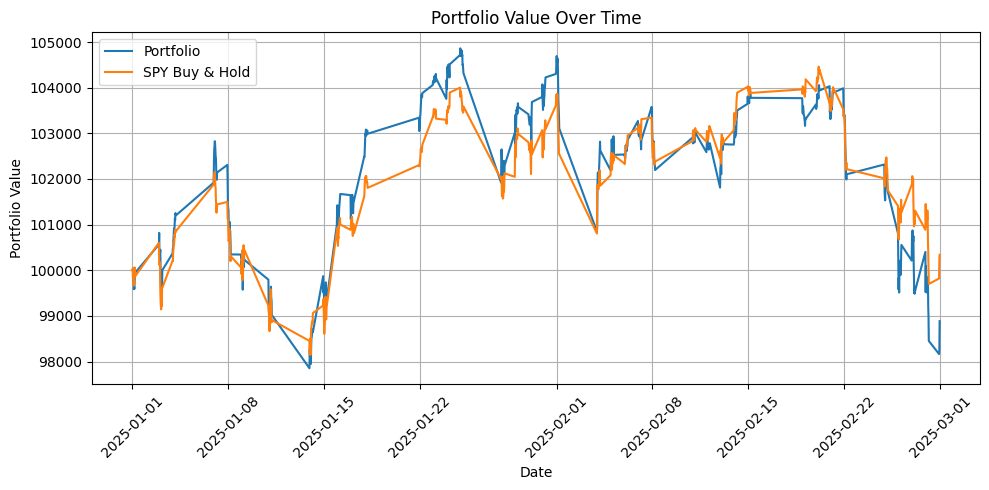

In [283]:
import matplotlib.pyplot as plt

# Drop rows with NA values
cleaned_data = trading_results.dropna(subset=['Portfolio_Value', 'SPY_Buy_Hold_Value'])  # Specify columns you care about

# Plotting
plt.figure(figsize=(10, 5))
plt.plot(cleaned_data['Date'], cleaned_data['Portfolio_Value'], label='Portfolio')
# plt.plot(cleaned_data['Date'], cleaned_data['BTC_Buy_Hold_Value'], label='BTC Buy & Hold')  # Uncomment if needed
plt.plot(cleaned_data['Date'], cleaned_data['SPY_Buy_Hold_Value'], label='SPY Buy & Hold')

# Title and labels
plt.title('Portfolio Value Over Time')
plt.xlabel('Date')
plt.ylabel('Portfolio Value')

# Add legend
plt.legend(loc='upper left')  # Adjust location as needed

plt.grid()
plt.xticks(rotation=45)
plt.tight_layout()  # Adjust layout
plt.show()
